## Recurrent Neural Network (RNN)-Based Sentiment Analysis on Twitter Data

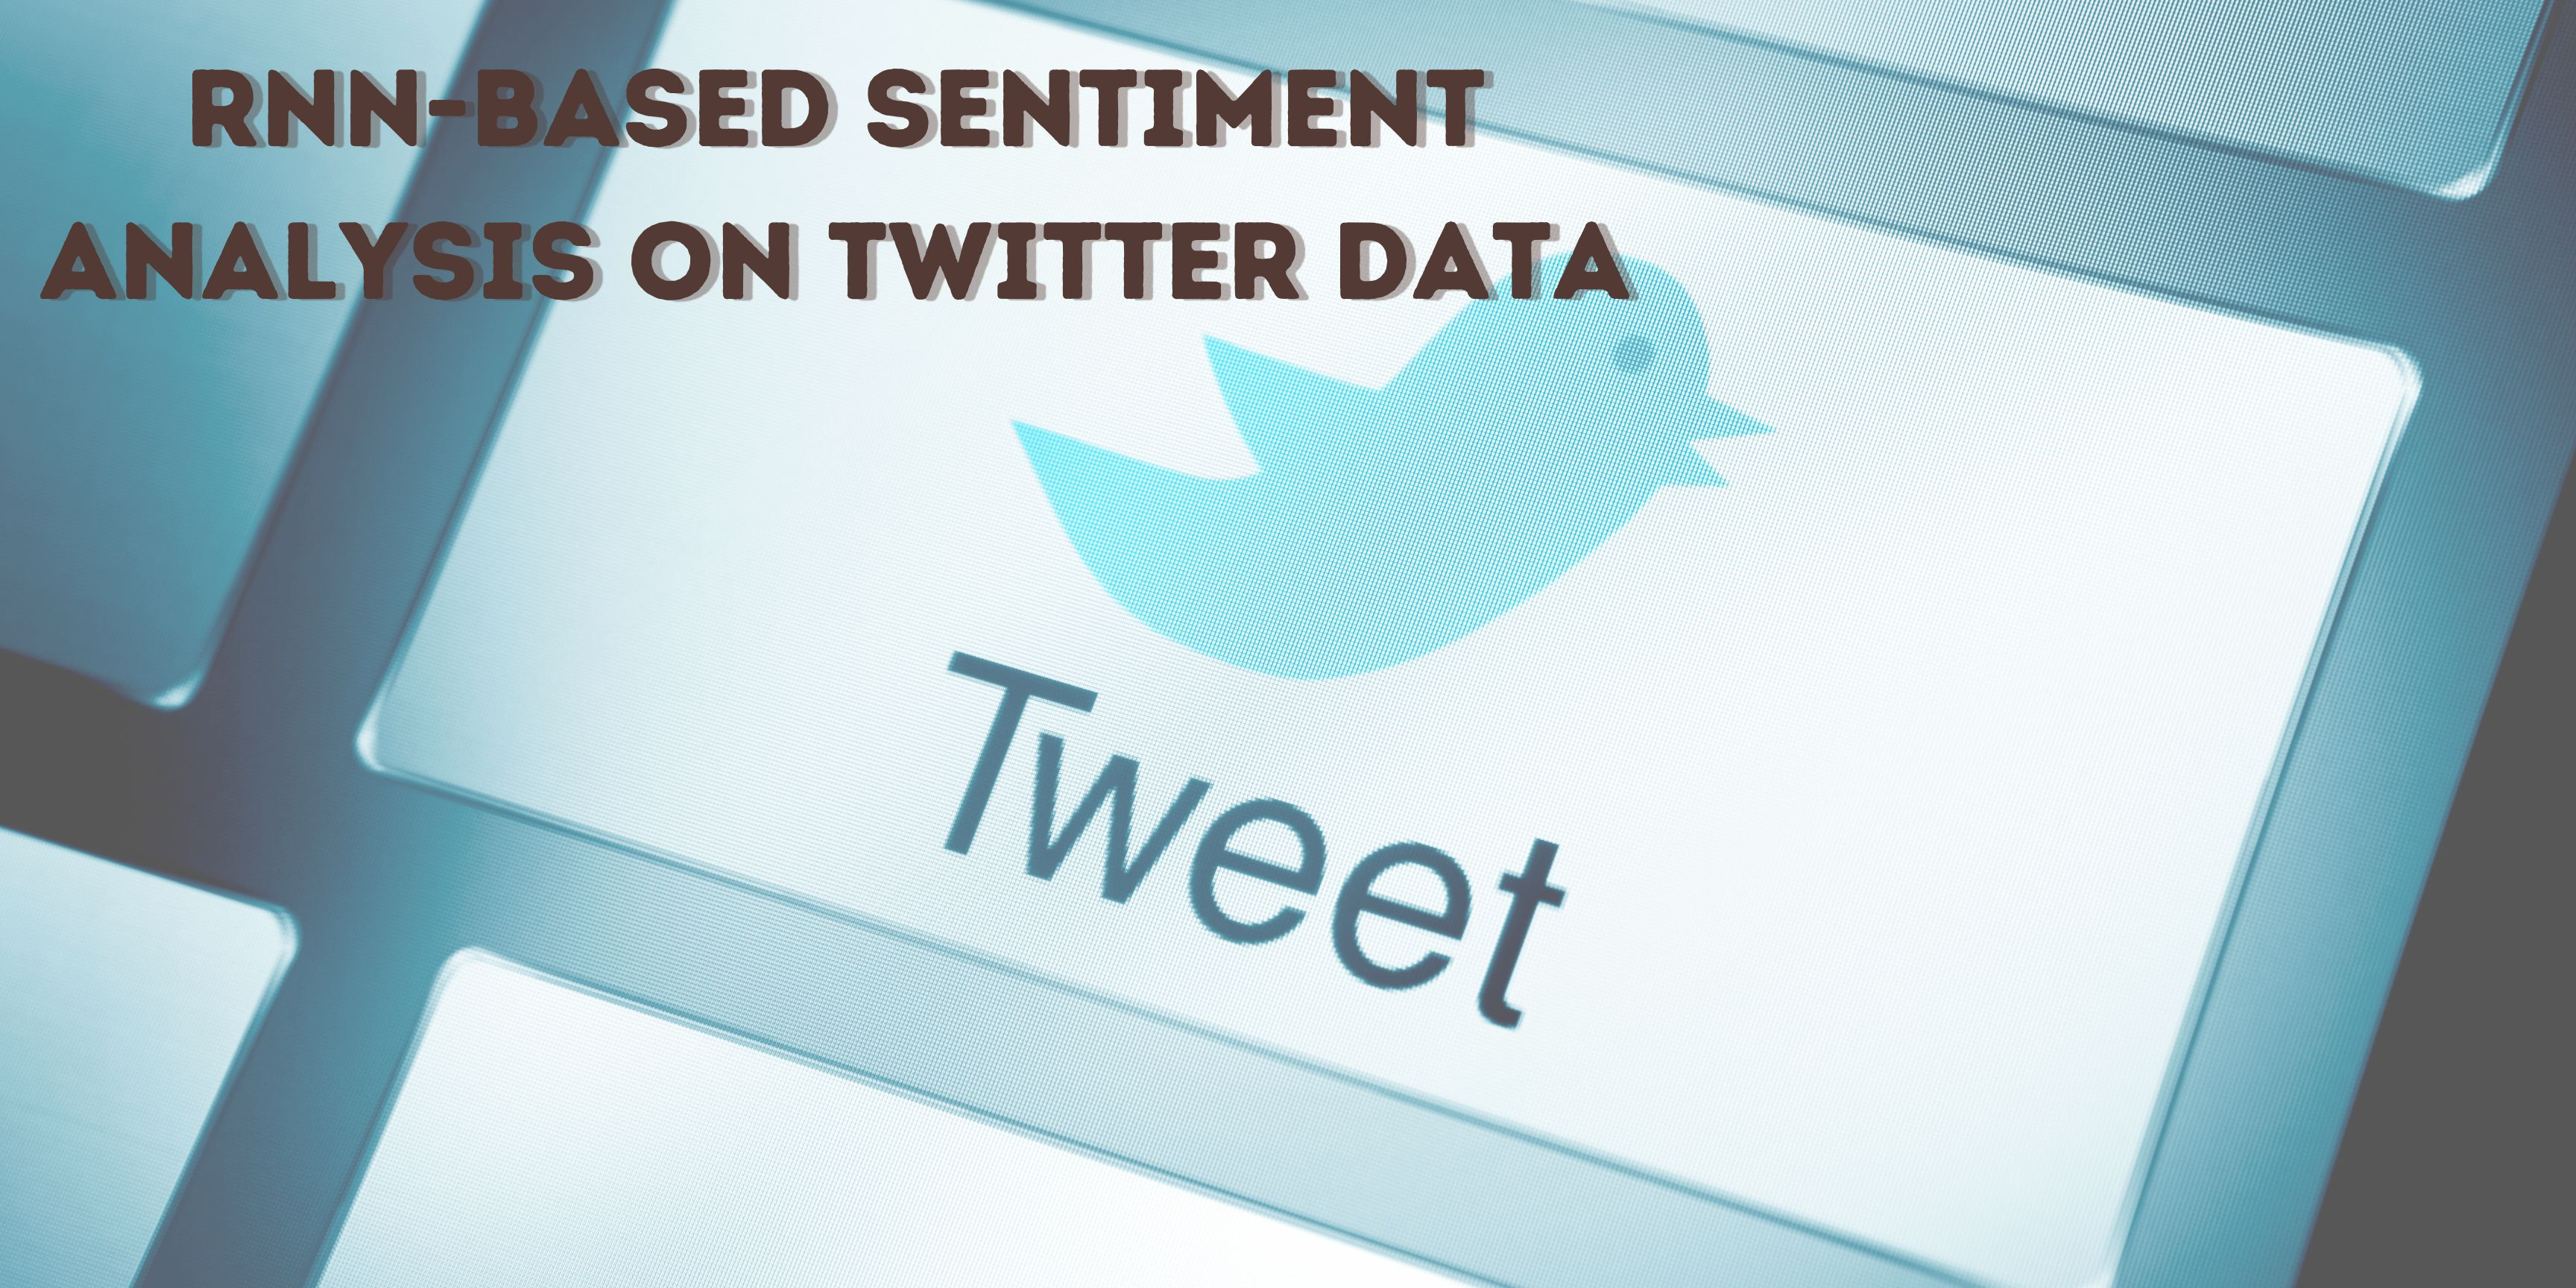

### Source of Dataset

Kaggle: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/data

### Background

This notebook explores the application of sentiment analysis on Twitter Tweets using a dataset. The analysis begins with preprocessing steps, where the NLTK library is employed for text normalization, including the removal of stopwords, punctuation, and lemmatization. The processed text is then utilized to train a sentiment analyzer based on a recurrent neural network (RNN).

### Import Essential Libraries

In [137]:
# import essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# import the essential dependencies for construct RNN network using keras module
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Load the Dataset

In [18]:
# load the dataset
data = pd.read_csv('../data/Tweets.csv')

# check the dimension of the dataset
numrow, numcol = data.shape
print(f'The dataset contains {numrow} rows and {numcol} columns.')

# check the attributes in the dataset
attributes = data.columns
print('Attibutes in the dataset:', attributes)

# view the first 5 rows of the dataset
display(data.head(n=5))

The dataset contains 27481 rows and 4 columns.
Attibutes in the dataset: Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [19]:
# summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [20]:
# check the duplicates and missing value in each attribute
print('Total number of duplicate records in the dataset:', data.duplicated().sum())
print('Total number of missing value in each attributes:')
print(data.isna().sum())

Total number of duplicate records in the dataset: 0
Total number of missing value in each attributes:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [21]:
# remove the instance(s) where the text column is empty
data = data[~data['text'].isna()]

In [22]:
# textID & selected_text will not be used in the analysis -- remove from the dataframe
data.drop(columns=['textID', 'selected_text'], axis=1, inplace=True)

In [23]:
# let's check how many categories in the 'sentiment' column
data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

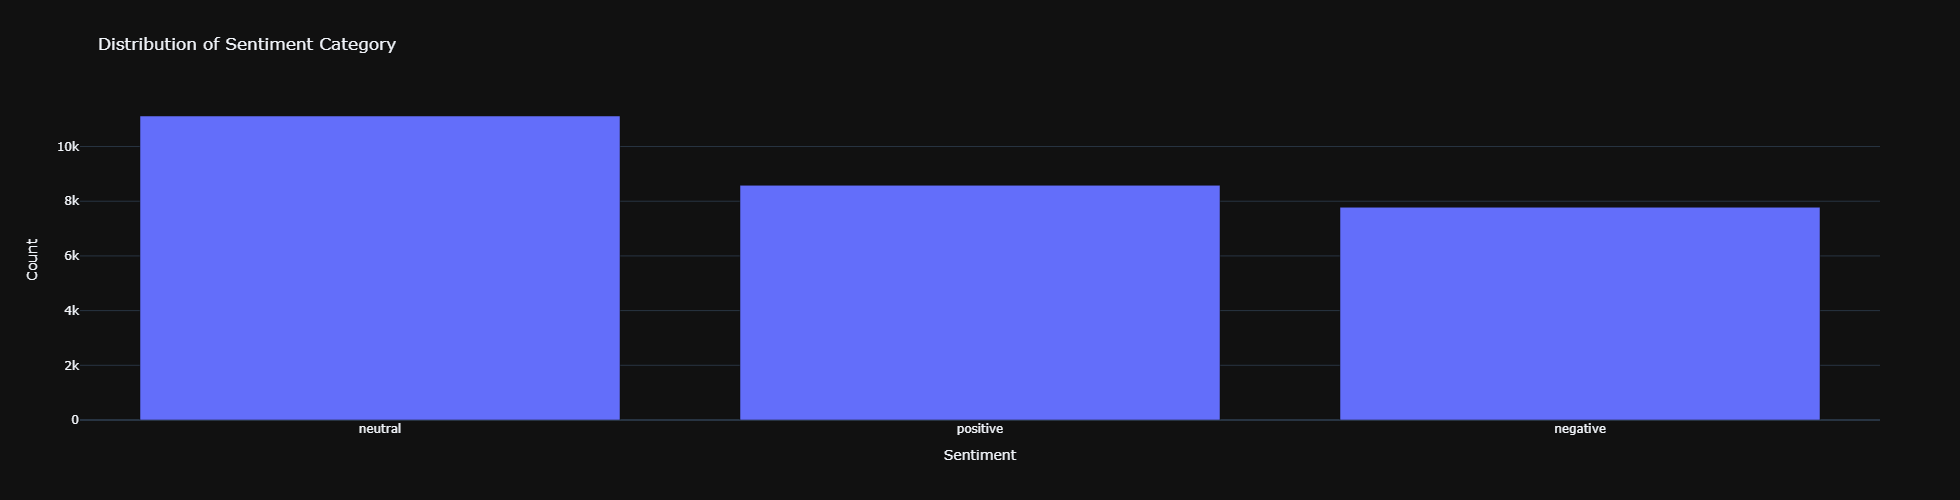

In [24]:
# visualization of the disribution of each sentiment category in the dataset
sentiment = data['sentiment'].value_counts()
sentiment_df = pd.DataFrame(sentiment).reset_index()
sentiment_df.columns = ['Sentiment', 'Count']

fig = px.bar(sentiment_df, 
             x='Sentiment', y='Count', 
             width=800, height=500, 
             template='plotly_dark', 
             title='Distribution of Sentiment Category')

fig.update_layout(
    xaxis = dict(
        title = 'Sentiment'
    ),
    yaxis = dict(
        title = 'Count'
    )
)

fig.show()

### Text Preprocessing

In [28]:
# define a function for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import re

pattern = r'[^\w\s]' #  matches any character that is not a word character (\w) or whitespace (\s)

stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def text_normalization(text):
    cleaned_text = re.sub(pattern, '', text)                                   # remove punctuation
    lemmatized_text = lemmatizer.lemmatize(cleaned_text)                       # lemmatization
    tokens = word_tokenize(lemmatized_text)                                    # tokenization
    fil_tokens = [token for token in tokens if token.lower() not in stopwords] # remove stopwords
    processed_text = ' '.join(fil_tokens)
    return processed_text

In [29]:
# insert a new column with normalized text
data['normalized_text'] = data['text'].apply(lambda x: text_normalization(x))

In [31]:
# create a new column to calculate the number of word (token) in the normalized text

# define a function to count the tokens
def count_token(text):
    tokens = word_tokenize(text)
    return len(tokens)

data['token_number'] = data['normalized_text'].apply(lambda x: count_token(x))

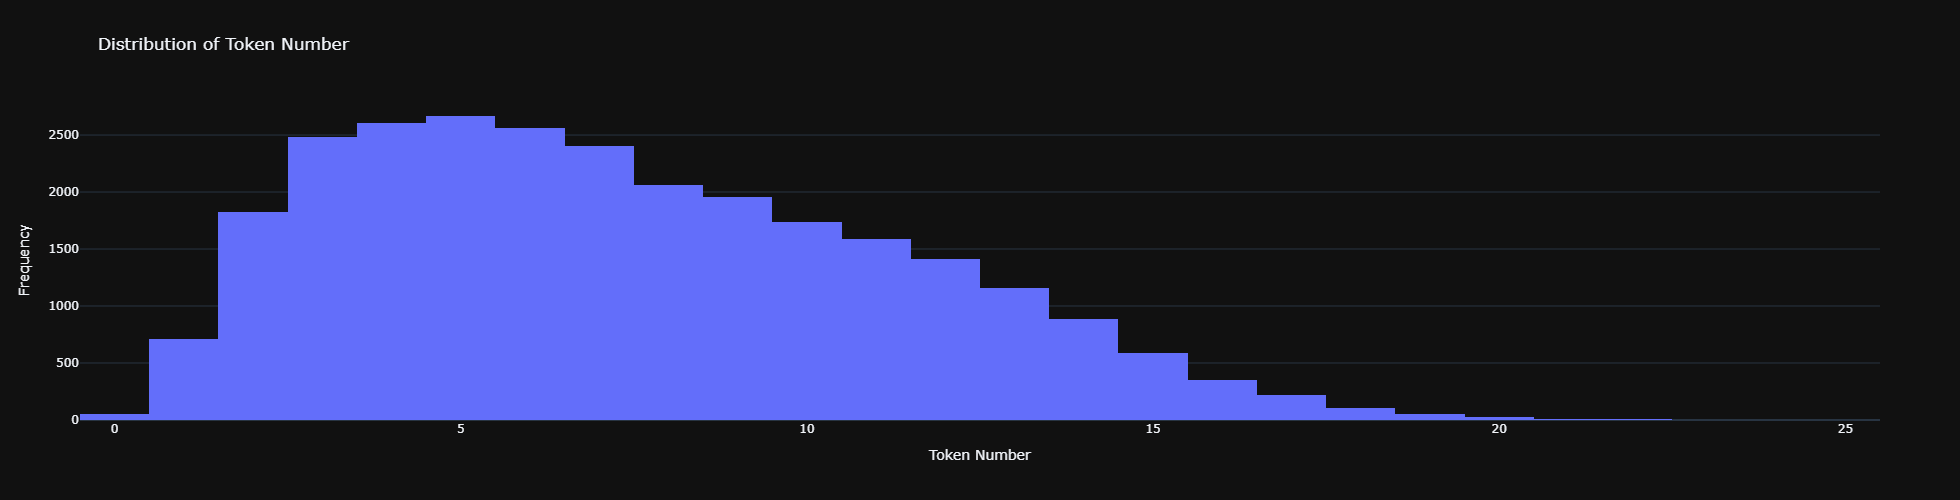

In [33]:
# visualize the distribution of the token number in the normalized text
fig = px.histogram(data, 
                   x='token_number', 
                   width=800, height=500, 
                   template='plotly_dark', 
                   title='Distribution of Token Number')

fig.update_layout(
    xaxis = dict(
        title = 'Token Number'
    ),
    yaxis = dict(
        title = 'Frequency'
    )
)

fig.show()

### Data Splitting

In [34]:
# split the dataset into train and test dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['sentiment'], shuffle=True, random_state=122)

# check the dimension od the train and test dataset
print('Dimension of the training dataset:', train.shape)
print('Dimension of the test dataset:', test.shape)

Dimension of the training dataset: (21984, 4)
Dimension of the test dataset: (5496, 4)


In [35]:
# segregate the feature matrix and target vector from the train and test dataset
Xtrain = train['normalized_text']
ytrain = train['sentiment']

Xtest = test['normalized_text']
ytest = test['sentiment']

### Data Preprocessing

In [41]:
# label encoding the target vector
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

ytrain_encoded = label_encoder.fit_transform(ytrain)
ytest_encoded = label_encoder.transform(ytest)

In [44]:
# initialize the tokenizer
tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')

# fit the tokenize with Xtrain text
tokenizer.fit_on_texts(Xtrain)        

In [53]:
# training data
# convert the texts to sequence
train_sequences = tokenizer.texts_to_sequences(Xtrain)
# pad the sequences
train_padded_sequence = pad_sequences(train_sequences, padding='post')

# test data
test_sequences = tokenizer.texts_to_sequences(Xtest)
# pad the sequences
test_padded_sequence = pad_sequences(test_sequences, padding='post')

#### Note

**.fit_on_texts()**
1. processes the training text and builds the vocabulary of the tokenizer based on word frequency
2. each unique word in the training text is assigned a unique integer index
3. tokenizer builds a word index dictionary (word_index) where keys are words and values are their corresponding indices
4. tokenizer also counts the occurrences of each word and stores them in a word_counts dictionary

**.texts.to_sequences()**
1. used to convert each text in the dataset (train and test) into sequences of integers
2. each word in the texts is replaced with its corresponding integer index from the word_index created during the fitting step

**pad_sequences()**
1. after converting text sequences into integer sequences (train_sequences and test_sequences), pad_sequences() is used to ensure that all sequences have the same length (max_length) 
2. necessary because neural networks typically require input data of uniform length
3. padding ensures that shorter sequences are padded with zeros to match the length of the longest sequence in the dataset

### Network Construction

In [98]:
# define the hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = train_padded_sequence.shape[1]

In [115]:
# define the RNN model architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Dropout(0.3),
    SimpleRNN(units=32, return_sequences=True),
    Dropout(0.4),
    SimpleRNN(units=32),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

In [138]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (32, 25, 16)           │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (32, 25, 16)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (32, 25, 32)           │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (32, 25, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 3)                │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,747 (639.64 KB)

 Trainable params: 163,747 (639.64 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from tensorflow.keras.callbacks import EarlyStopping

# define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [118]:
# train the RNN network with early stopping callback
history = model.fit(train_padded_sequence, ytrain_encoded, epochs=10, validation_data=(test_padded_sequence, ytest_encoded), callbacks=[early_stopping])

Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3809 - loss: 1.1241 - val_accuracy: 0.3830 - val_loss: 1.1224
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5263 - loss: 0.9495 - val_accuracy: 0.5111 - val_loss: 0.9631
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6524 - loss: 0.7740 - val_accuracy: 0.5464 - val_loss: 0.9347
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7397 - loss: 0.6510 - val_accuracy: 0.5542 - val_loss: 0.9129
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7841 - loss: 0.5654 - val_accuracy: 0.6401 - val_loss: 0.8561
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8076 - loss: 0.5225 - val_accuracy: 0.6043 - val_loss: 0.9000
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8316 - loss: 0.4686 - val_accuracy: 0.5408 - val_loss: 1.0253
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8426 - loss: 0.4487 - val_accuracy: 

### Training Performance

,accuracy,loss,val_accuracy,val_loss
0,0.423490,1.081631,0.383006,1.122410
1,0.544032,0.925286,0.511099,0.963137
2,0.666894,0.759030,0.546397,0.934701
3,0.733579,0.662151,0.554221,0.912922
4,0.772562,0.588261,0.640102,0.856101
5,0.797171,0.542766,0.604258,0.899953
6,0.818368,0.497789,0.540757,1.025272
7,0.835062,0.461902,0.602984,0.960345


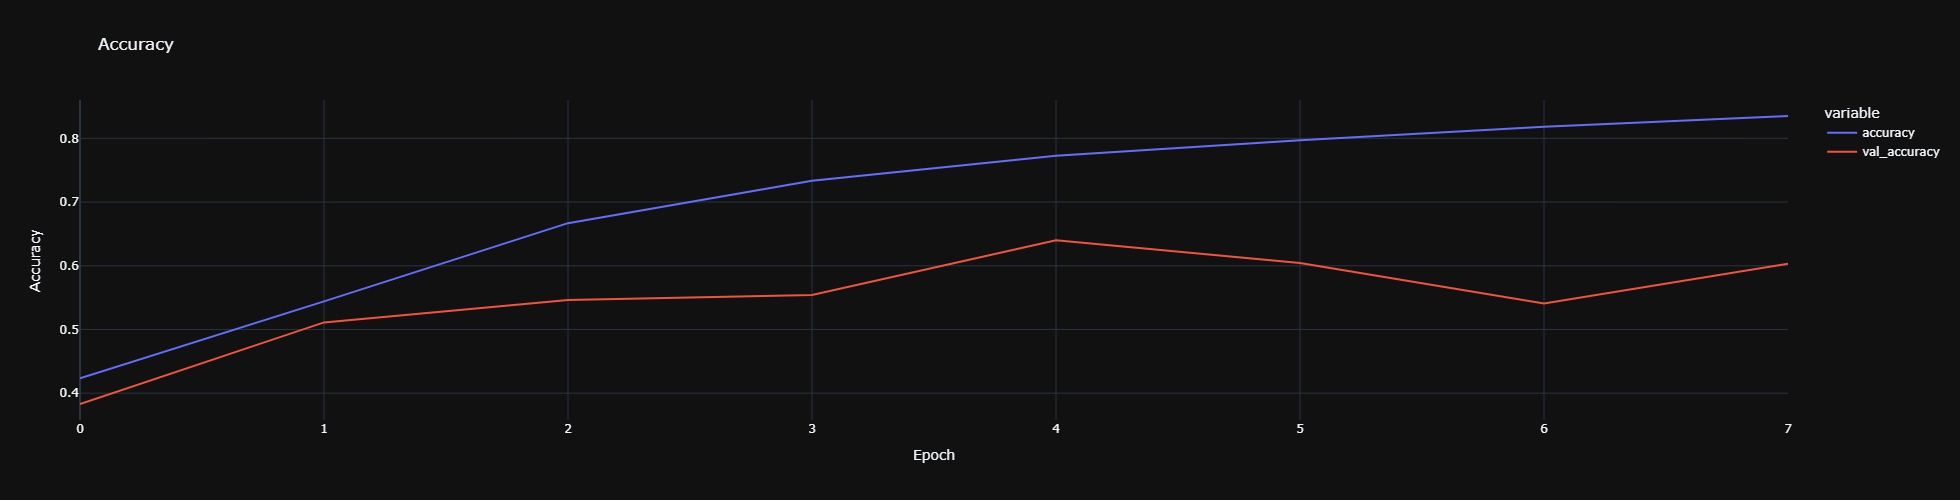

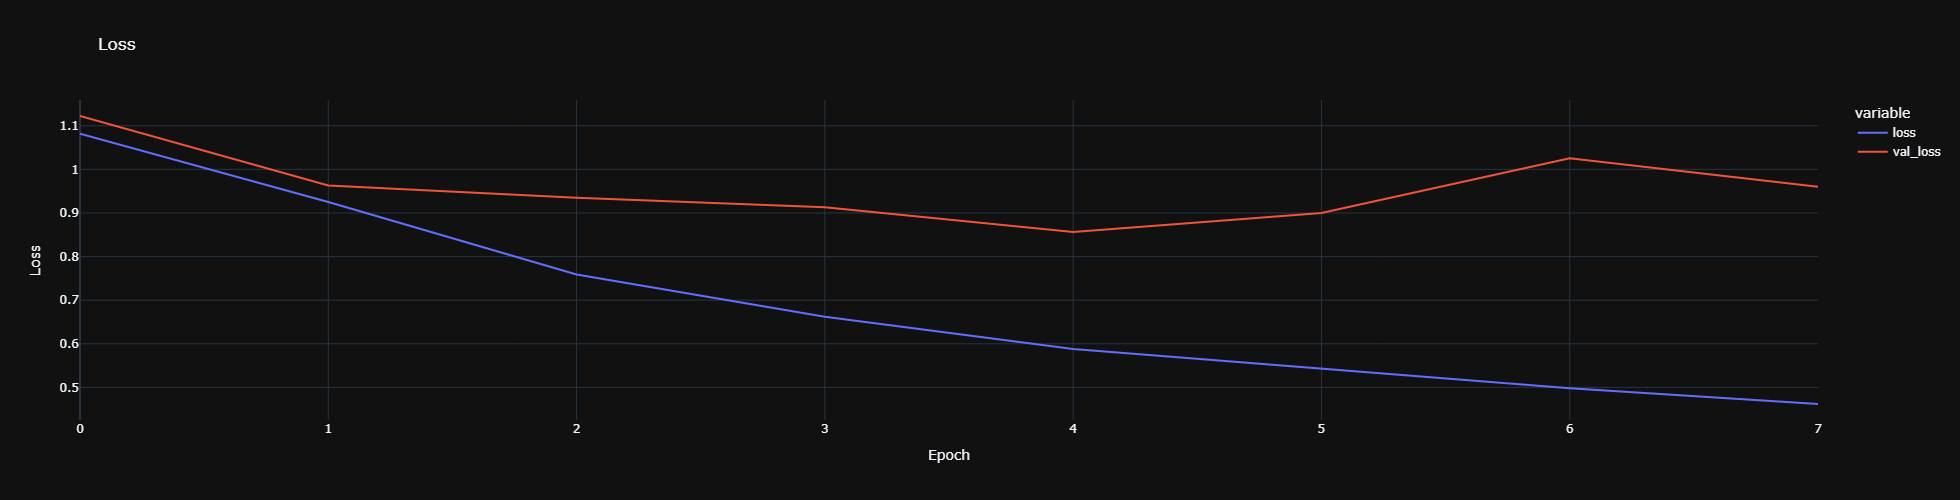

In [119]:
# visualize the training progress
# plot the graph of loss and accuracy epoch-by-epoch

# create a dataframe for the training history
history_df = pd.DataFrame(history.history)
display(history_df)

# subset the accuracy and loss dataframe from the history_df
accuracy_df = history_df[['accuracy','val_accuracy']]
loss_df = history_df[['loss','val_loss']]

# visualize the accuracy during training progress
fig = px.line(accuracy_df, width=800, height=500, template='plotly_dark', title='Accuracy')

fig.update_layout(
    xaxis = dict(
        title = 'Epoch'
    ),
    yaxis = dict(
        title = 'Accuracy'
    )
)

fig.show()

# visualize the loss during training progress
fig = px.line(loss_df, width = 800, height=500, template='plotly_dark', title='Loss')

fig.update_layout(
    xaxis = dict(
        title = 'Epoch'
    ),
    yaxis = dict(
        title = 'Loss'
    )
)

fig.show()

### Model Performance

In [134]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

def model_performance(X, y, model):
    # predict the classes for the test set
    ypred = model.predict(X)
    ypred_classes = ypred.argmax(axis=-1)
    
    accuracy = round(accuracy_score(y, ypred_classes), 3)
    precision = round(precision_score(y, ypred_classes, average='weighted'), 3)
    recall = round(recall_score(y, ypred_classes, average='weighted'), 3)
    f1 = round(f1_score(y, ypred_classes, average='weighted'), 3)
    #AUC = round(roc_auc_score(y, ypred), 3)
    
    print('Key Peformance Metrics:\n')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    cm = confusion_matrix(y, ypred_classes)
    sns.heatmap(cm, annot=True, fmt='.4g', cmap='BuPu', cbar=False)

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Key Peformance Metrics:

Accuracy: 0.64
Precision: 0.644
Recall: 0.64
F1 Score: 0.639


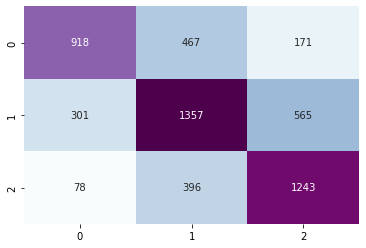

In [135]:
model_performance(test_padded_sequence, ytest_encoded, model)